# Exploring the New York City Taxi Data with Arkouda + Pandas/NumPy

This notebook shows some examples of how to interoperate between Pandas and Arkouda at a small scale on a few-GB workstation. This same notebook would run with a multi-node Arkouda instance on an HPC with TB of data.

Arkouda is not trying to replace Pandas but to allow for some Pandas-style operation at a much larger scale. In our experience Pandas can handle dataframes up to about **500 million rows** on a sufficently capable compute server before performance becomes a real issue. Arkouda breaks the shared memory paradigm and scales its operations to distributed dataframes with **hundreds of billions of rows**, maybe even a trillion. In practice we have run Arkouda server operations on columns of one trillion elements running on 512 compute nodes. This yielded a **>20TB dataframe** in Arkouda.

**Outline**
- Data Preparation
  - Get Data
  - Convert Data
  - Load Data
- Data Exploration
  - Summarization
  - Histograms
  - Logical Indexing/Filtering
  - Time Data
  - Lookup Tables
  - GroupBy-Aggregate
  - Broadcast
  - Integrate with Pandas

# Data Preparation

## Download New York City Taxi Data
----------------------------------
[Yellow Trips Data Dictionary](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

[NYC Yellow Taxi Trip Records Jan 2020](https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2020-01.csv)

[Green Trips Data Dictionary](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf)

[NYC Green  Taxi Trip Records Jan 2020](https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2020-01.csv)

[NYC Taxi Zone Lookup Table](https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv)

[NYC Taxi Zone Shapefile](https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip)

## Convert and Load Data

2 methods:
* Load in python (e.g. with pandas) and transfer to arkouda
  * Good for prototyping with small data
* Convert to HDF5 (in separate process) and read directly with arkouda
  * Best for large datasets
  
#### Dtypes Supported in HDF5
Arkouda can only read these HDF5 dtypes
* int (any width) -> int64
* float (any width) -> float64
* custom string format -> ak.Strings

#### Additional Dtypes in Arkouda
Can cast/convert to these after loading raw data
* bool
* Datetime (from int64)
* Timedelta (from int64)

#### Prefer Integers!
They are fast and versatile (usable with GroupBy, Datetime, Timedelta, bit ops, etc.)

### Describe Data Format

In [1]:
!head /home/reusters/data/green_tripdata_2020-01.csv

In [2]:
%%file NYCTaxi_format.py

import numpy as np

OPTIONS = {}

def YNint(yn):
    return (0, 1)[yn.upper() in 'YES']

def nullint(x):
    try:
        return np.int64(x)
    except:
        return np.int64(-1)

yellow_format = {'sep': ',',
                 'header': 0,
                 'parse_dates':['tpep_dropoff_datetime', 'tpep_pickup_datetime'],
                 'infer_datetime_format': True,
                 'converters': {'store_and_fwd_flag': YNint,
                                'VendorID': nullint,
                                'RatecodeID': nullint,
                                'PULocationID': nullint,
                                'DOLocationID': nullint,
                                'passenger_count': nullint,
                                'payment_type': nullint,
                                'trip_type': nullint}}

OPTIONS['yellow'] = yellow_format

green_format = yellow_format.copy()
green_format['parse_dates'] = ['lpep_dropoff_datetime', 'lpep_pickup_datetime']
OPTIONS['green'] = green_format

Overwriting NYCTaxi_format.py


### Method 1: CSV --> Pandas --> Arkouda

In [3]:
import pandas as pd
import NYCTaxi_format as taxi
import arkouda as ak
ak.connect(connect_url="tcp://localhost:5555")

connected to arkouda server tcp://*:5555


    _         _                   _       
   / \   _ __| | _____  _   _  __| | __ _ 
  / _ \ | '__| |/ / _ \| | | |/ _` |/ _` |
 / ___ \| |  |   < (_) | |_| | (_| | (_| |
/_/   \_\_|  |_|\_\___/ \__,_|\__,_|\__,_|
                                          

Client Version: 2020.07.07


In [4]:
pdgreen = pd.read_csv('/home/reusters/data/green_tripdata_2020-01.csv', **taxi.OPTIONS['green'])

In [5]:
# transfer columns of DataFrame to arkouda
def ak_create_akdict_from_df(df):
    akdict = {}
    for cname in df.keys():
        if df[cname].dtype.name == 'object':
            akdict[cname] = ak.from_series(df[cname],dtype=np.str)
        else:
            akdict[cname] = ak.from_series(df[cname])

    return akdict

In [6]:
green_from_pandas = ak_create_akdict_from_df(pdgreen)

### Method 2: CSV --> HDF5 --> Arkouda

Arkouda comes with a CSV to HDF5 converter in the repo. It uses the NYCTaxi_format.py file we defined above.

In [7]:
!python3 /home/reusters/arkouda/converter/csv2hdf.py \
--formats-file=/home/reusters/ArkoudaNotebooks/NYCTaxi_format.py \
--format=green \
--outdir=/home/reusters/data/ \
/home/reusters/data/green_tripdata_2020-01.csv

Columns to be extracted:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               1000 non-null   int64         
 1   lpep_pickup_datetime   1000 non-null   datetime64[ns]
 2   lpep_dropoff_datetime  1000 non-null   datetime64[ns]
 3   store_and_fwd_flag     1000 non-null   int64         
 4   RatecodeID             1000 non-null   int64         
 5   PULocationID           1000 non-null   int64         
 6   DOLocationID           1000 non-null   int64         
 7   passenger_count        1000 non-null   int64         
 8   trip_distance          1000 non-null   float64       
 9   fare_amount            1000 non-null   float64       
 10  extra                  1000 non-null   float64       
 11  mta_tax                1000 non-null   float64       
 12  tip_amount             1000 non-null  

In [8]:
# Can skip this if already connected above
import arkouda as ak
ak.connect(connect_url="tcp://localhost:5555")

connected to arkouda server tcp://*:5555


In [9]:
green_from_HDF5 = ak.read_all('/home/reusters/data/green_tripdata_2020-01.hdf')

### Same Result from Both Methods

In [10]:
def frames_are_equal(a, b):
    # Ensure same columns
    if a.keys() != b.keys():
        return False
    # Ensure same column dtypes
    if not all(a[k].dtype == b[k].dtype for k in a):
        return False
    # Compare column values
    for k in a:
        # Workaround until ak.isna() is implemented
        # Because nan != nan
        if a[k].dtype == ak.float64:
            cmp = ak.cast(a[k], 'int64') == ak.cast(b[k], 'int64')
        else:
            cmp = a[k] == b[k]
        if not cmp.all():
            return False
    return True

In [11]:
frames_are_equal(green_from_HDF5, green_from_pandas)

True

In [12]:
# Proceed with just one, since they are equivalent
data = green_from_HDF5

### Convert Columns to Specialized Dtypes

In [13]:
data['lpep_pickup_datetime'] = ak.Datetime(data['lpep_pickup_datetime'])
data['lpep_dropoff_datetime'] = ak.Datetime(data['lpep_dropoff_datetime'])
data['store_and_fwd_flag'] = (data['store_and_fwd_flag'] == 1)

In [14]:
data

{'DOLocationID': array([264, 65, 228, ..., 241, 17, 124]),
 'PULocationID': array([264, 66, 181, ..., 244, 68, 22]),
 'RatecodeID': array([1, 5, 1, ..., -1, -1, -1]),
 'VendorID': array([2, 2, 2, ..., -1, -1, -1]),
 'congestion_surcharge': array([0, 0, 0, ..., nan, nan, nan]),
 'ehail_fee': array([nan, nan, nan, ..., nan, nan, nan]),
 'extra': array([0.5, 0, 0.5, ..., 2.75, 2.75, 2.75]),
 'fare_amount': array([3.5, 20, 10.5, ..., 25.949999999999999, 30.390000000000001, 42.200000000000003]),
 'improvement_surcharge': array([0.29999999999999999, 0.29999999999999999, 0.29999999999999999, ..., 0.29999999999999999, 0.29999999999999999, 0.29999999999999999]),
 'lpep_dropoff_datetime': Datetime(['2019-12-18 15:54:39',
           '2020-01-01 00:56:39',
           '2020-01-01 00:52:49',
           ... ,
           '2020-02-01 00:10:00',
           '2020-02-01 00:04:00',
           '2020-02-01 00:01:00'],
          dtype='datetime64[ns]'),
 'lpep_pickup_datetime': Datetime(['2019-12-18 15:52:30'

In [15]:
rows = data['VendorID'].size
numbytes = sum(v.size*v.itemsize for v in data.values())

In [16]:
print(f'{rows:,} rows\n{numbytes:,} bytes')

447,770 rows
68,508,810 bytes


# Exploration

## Descriptive Statistics

In [17]:
def describe(x):
    fmt = 'mean: {}\nstd : {}\nmin : {}\nmax : {}'
    if x.dtype == ak.float64:
        fmt = fmt.format(*['{:.2f}' for _ in range(4)])
    print(fmt.format(x.mean(), x.std(), x.min(), x.max()))

In [18]:
describe(data['fare_amount'])

mean: 15.84
std : 12.69
min : -210.00
max : 753.00


## Histograms

In [19]:
import numpy as np
from matplotlib import pyplot as plt

def hist(x, bins, log=True):
    assert bins > 0
    # Compute histogram counts in arkouda
    h = ak.histogram(x, bins)
    # Compute bins in numpy
    if isinstance(x, ak.Datetime):
        # Matplotlib has trouble plotting np.datetime64 and np.timedelta64
        bins = ak.date_range(x.min(), x.max(), periods=bins).to_ndarray().astype('int')
    elif isinstance(x, ak.Timedelta):
        bins = ak.timedelta_range(x.min(), x.max(), periods=bins).to_ndarray().astype('int')
    else:
        bins = np.linspace(x.min(), x.max(), bins+1)[:-1]
    # Bring h over to numpy for plotting
    plt.bar(bins, h.to_ndarray(), width=bins[1]-bins[0])
    if log:
        plt.yscale('log')

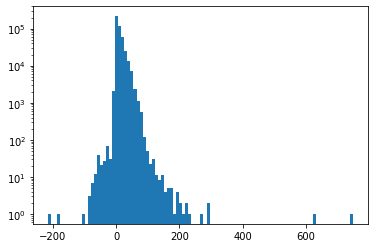

In [20]:
hist(data['fare_amount'], 100)

## Logical Indexing (Filters)
Find non-negative fares

In [21]:
nonneg = data['fare_amount'] >= 0
print(f'{nonneg.sum() / nonneg.size :.1%} of fares are non-negative')

99.7% of fares are non-negative


Select only non-negative fares for computation

In [22]:
describe(data['fare_amount'][nonneg])

mean: 15.91
std : 12.62
min : 0.00
max : 753.00


Make new data dict with only non-negative fares

In [23]:
data_nonneg = {k:v[nonneg] for k, v in data.items()}

In [24]:
data_nonneg

{'DOLocationID': array([264, 65, 228, ..., 241, 17, 124]),
 'PULocationID': array([264, 66, 181, ..., 244, 68, 22]),
 'RatecodeID': array([1, 5, 1, ..., -1, -1, -1]),
 'VendorID': array([2, 2, 2, ..., -1, -1, -1]),
 'congestion_surcharge': array([0, 0, 0, ..., nan, nan, nan]),
 'ehail_fee': array([nan, nan, nan, ..., nan, nan, nan]),
 'extra': array([0.5, 0, 0.5, ..., 2.75, 2.75, 2.75]),
 'fare_amount': array([3.5, 20, 10.5, ..., 25.949999999999999, 30.390000000000001, 42.200000000000003]),
 'improvement_surcharge': array([0.29999999999999999, 0.29999999999999999, 0.29999999999999999, ..., 0.29999999999999999, 0.29999999999999999, 0.29999999999999999]),
 'lpep_dropoff_datetime': Datetime(['2019-12-18 15:54:39',
           '2020-01-01 00:56:39',
           '2020-01-01 00:52:49',
           ... ,
           '2020-02-01 00:10:00',
           '2020-02-01 00:04:00',
           '2020-02-01 00:01:00'],
          dtype='datetime64[ns]'),
 'lpep_pickup_datetime': Datetime(['2019-12-18 15:52:30'

## Time Data

In [25]:
data['ride_duration'] = data['lpep_dropoff_datetime'] - data['lpep_pickup_datetime']

In [26]:
data['ride_duration']

Timedelta(['0 days 00:02:09',
           '0 days 00:10:41',
           '0 days 00:11:11',
           ... ,
           '0 days 00:13:00',
           '0 days 00:37:00',
           '0 days 00:25:00'],
          dtype='timedelta64[ns]')

In [27]:
data['ride_duration'].min(), data['ride_duration'].max()

(Timedelta('-1 days +23:59:50'), Timedelta('0 days 23:59:34'))

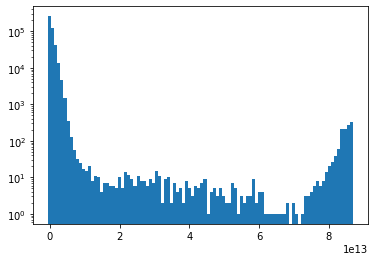

In [28]:
hist(data['ride_duration'], 100)

## Taxi Zone Lookup Table

### Use Method 1: CSV --> Pandas --> Arkouda

In [29]:
def cvt_to_string(v):
    try:
        if v == '':
            return 'N/A'
        else:
            return str(v)
    except:
        return 'N/A'

# read the taxi-zone-lookup-table
cvt = {'Borough':cvt_to_string, 'Zone':cvt_to_string, 'service_zone':cvt_to_string}
tzlut = pd.read_csv("/home/reusters/data/taxi+_zone_lookup.csv",converters=cvt)

# location id is 1-based, index is 0-based
# fix it up to be aligned with index in data frame
# which means add row zero
top_row = pd.DataFrame({'LocationID': [0], 'Borough': ['N/A'], 'Zone': ['N/A'], 'service_zone': ['N/A']})
tzlut = pd.concat([top_row, tzlut]).reset_index(drop = True)

In [30]:
tzlut

,LocationID,Borough,Zone,service_zone
0,0,N/A,N/A,N/A
1,1,EWR,Newark Airport,EWR
2,2,Queens,Jamaica Bay,Boro Zone
3,3,Bronx,Allerton/Pelham Gardens,Boro Zone
4,4,Manhattan,Alphabet City,Yellow Zone
...,...,...,...,...
261,261,Manhattan,World Trade Center,Yellow Zone
262,262,Manhattan,Yorkville East,Yellow Zone
263,263,Manhattan,Yorkville West,Yellow Zone
264,264,Unknown,NV,N/A


### Convert dataframe to dictionary of Arkouda arrays

In [31]:
# convert data frame with strings and int64 data
aktzlut = ak_create_akdict_from_df(tzlut)

In [32]:
aktzlut

{'LocationID': array([0, 1, 2, ..., 263, 264, 265]),
 'Borough': array(['N/A', 'EWR', 'Queens', ... , 'Manhattan', 'Unknown', 'Unknown']),
 'Zone': array(['N/A', 'Newark Airport', 'Jamaica Bay', ... , 'Yorkville West', 'NV', 'NA']),
 'service_zone': array(['N/A', 'EWR', 'Boro Zone', ... , 'Yellow Zone', 'N/A', 'N/A'])}

### Apply Lookup Table

In [33]:
(aktzlut['LocationID'] == ak.arange(aktzlut['LocationID'].size)).all()

True

In [34]:
data['PUBorough'] = aktzlut['Borough'][data['PULocationID']]
data['DOBorough'] = aktzlut['Borough'][data['DOLocationID']]

In [35]:
data['PUZone'] = aktzlut['Zone'][data['PULocationID']]
data['DOZone'] = aktzlut['Zone'][data['DOLocationID']]

In [36]:
data

{'DOLocationID': array([264, 65, 228, ..., 241, 17, 124]),
 'PULocationID': array([264, 66, 181, ..., 244, 68, 22]),
 'RatecodeID': array([1, 5, 1, ..., -1, -1, -1]),
 'VendorID': array([2, 2, 2, ..., -1, -1, -1]),
 'congestion_surcharge': array([0, 0, 0, ..., nan, nan, nan]),
 'ehail_fee': array([nan, nan, nan, ..., nan, nan, nan]),
 'extra': array([0.5, 0, 0.5, ..., 2.75, 2.75, 2.75]),
 'fare_amount': array([3.5, 20, 10.5, ..., 25.949999999999999, 30.390000000000001, 42.200000000000003]),
 'improvement_surcharge': array([0.29999999999999999, 0.29999999999999999, 0.29999999999999999, ..., 0.29999999999999999, 0.29999999999999999, 0.29999999999999999]),
 'lpep_dropoff_datetime': Datetime(['2019-12-18 15:54:39',
           '2020-01-01 00:56:39',
           '2020-01-01 00:52:49',
           ... ,
           '2020-02-01 00:10:00',
           '2020-02-01 00:04:00',
           '2020-02-01 00:01:00'],
          dtype='datetime64[ns]'),
 'lpep_pickup_datetime': Datetime(['2019-12-18 15:52:30'

## GroupBy: Construct a Graph

Directed graph from PULocationID --> DOLocationID

In [37]:
byloc = ak.GroupBy([data['PULocationID'], data['DOLocationID']])

In [38]:
byloc.unique_keys

[array([1, 1, 3, ..., 265, 265, 265]), array([1, 264, 3, ..., 260, 264, 265])]

Edge weight is number of rides

Aggregation methods of `GroupBy` return tuple of (unique_keys, aggregate_values)

In [39]:
(u, v), w = byloc.count()

In [40]:
u, v, w

(array([1, 1, 3, ..., 265, 265, 265]),
 array([1, 264, 3, ..., 260, 264, 265]),
 array([2, 2, 9, ..., 1, 14, 73]))

## Broadcast: Find Rides with Anomalous Fares

Compute mean and std of fare by (pickup, dropoff)

In [41]:
_, mf = byloc.mean(data['fare_amount'])

In [42]:
sf = (byloc.sum(data['fare_amount']**2)[1] / w) - mf**2

Broadcast group values back to ride dataframe to compute z-scores of rides

In [43]:
data['fare_mean'] = byloc.broadcast(mf, permute=True)
data['fare_std'] = byloc.broadcast(sf, permute=True)

In [44]:
data['fare_z'] = (data['fare_amount'] - data['fare_mean']) / (data['fare_std'] + 1)

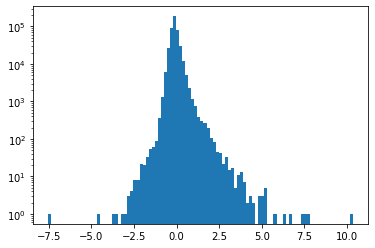

In [45]:
hist(data['fare_z'], 100)

## Bring Small Result Set Back to Pandas

In [46]:
exorbitant = (data['fare_z'] > 5)
exdf = pd.DataFrame({k: v[exorbitant].to_ndarray() for k, v in data.items()})

In [47]:
exdf

,DOLocationID,PULocationID,RatecodeID,VendorID,congestion_surcharge,ehail_fee,extra,fare_amount,improvement_surcharge,lpep_dropoff_datetime,...,trip_distance,trip_type,ride_duration,PUBorough,DOBorough,PUZone,DOZone,fare_mean,fare_std,fare_z
0,135,95,1,2,0.00,NaN,0.00,68.50,0.3,2020-01-04 13:48:56,...,20.13,1,0 days 01:25:33,Queens,Queens,Forest Hills,Kew Gardens Hills,9.347122,10.239756,5.262826
1,223,7,1,2,0.00,NaN,0.00,112.50,0.3,2020-01-05 15:52:40,...,18.51,1,0 days 02:52:36,Queens,Queens,Astoria,Steinway,7.941014,13.072258,7.430150
2,256,255,1,2,0.00,NaN,0.00,32.00,0.3,2020-01-07 10:49:37,...,6.64,1,0 days 00:47:10,Brooklyn,Brooklyn,Williamsburg (North Side),Williamsburg (South Side),5.729614,4.128608,5.122323
3,146,7,1,2,0.00,NaN,0.50,44.00,0.3,2020-01-10 01:02:50,...,14.27,1,0 days 00:41:21,Queens,Queens,Astoria,Long Island City/Queens Plaza,7.048724,5.829702,5.410379
4,152,166,1,1,0.00,NaN,0.00,50.00,0.3,2020-01-11 15:53:11,...,2.90,1,0 days 01:30:22,Manhattan,Manhattan,Morningside Heights,Manhattanville,5.656181,4.856363,7.571904
5,166,41,1,1,2.75,NaN,3.75,55.00,0.3,2020-01-11 17:47:01,...,13.60,1,0 days 01:10:40,Manhattan,Manhattan,Central Harlem,Morningside Heights,6.417887,5.278712,7.737592
6,236,74,2,2,2.75,NaN,0.00,52.00,0.3,2020-01-13 00:00:00,...,1.79,1,0 days 10:31:13,Manhattan,Manhattan,East Harlem North,Upper East Side North,9.758939,5.298839,6.706166
7,74,41,1,2,0.00,NaN,0.00,41.00,0.3,2020-01-12 16:02:26,...,13.68,1,0 days 00:34:43,Manhattan,Manhattan,Central Harlem,East Harlem North,6.694358,5.477669,5.295986
8,74,75,2,2,0.00,NaN,0.00,52.00,0.3,2020-01-16 01:30:15,...,0.38,1,0 days 00:00:30,Manhattan,Manhattan,East Harlem South,East Harlem North,6.395680,6.858080,5.803494
9,166,74,5,2,2.75,NaN,0.00,87.76,0.3,2020-01-26 05:06:39,...,30.45,1,0 days 03:05:02,Manhattan,Manhattan,East Harlem North,Morningside Heights,9.225326,6.543356,10.411106


In [48]:
worst = data['fare_z'].argmax()
{k:v[worst] for k, v in data.items()}

{'DOLocationID': 166,
 'PULocationID': 74,
 'RatecodeID': 5,
 'VendorID': 2,
 'congestion_surcharge': 2.75,
 'ehail_fee': nan,
 'extra': 0.0,
 'fare_amount': 87.76,
 'improvement_surcharge': 0.3,
 'lpep_dropoff_datetime': Timestamp('2020-01-26 05:06:39'),
 'lpep_pickup_datetime': Timestamp('2020-01-26 02:01:37'),
 'mta_tax': 0.0,
 'passenger_count': 2,
 'payment_type': 2,
 'store_and_fwd_flag': False,
 'tip_amount': 0.0,
 'tolls_amount': 6.12,
 'total_amount': 96.93,
 'trip_distance': 30.45,
 'trip_type': 1,
 'ride_duration': Timedelta('0 days 03:05:02'),
 'PUBorough': 'Manhattan',
 'DOBorough': 'Manhattan',
 'PUZone': 'East Harlem North',
 'DOZone': 'Morningside Heights',
 'fare_mean': 9.225325794291892,
 'fare_std': 6.543355857773392,
 'fare_z': 10.411105572432794}

## Disconnect from the server or shutdown the server

In [49]:
# disconnect or shutdown the server
#ak.disconnect()
#ak.shutdown()